In [9]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as mb

In [11]:
o = db.OpsimDatabase('/Users/lynnej/opsim/db/astro-lsst-01_2013.db')
propids, proptags = o.fetchPropInfo()
wfdfields = o.fetchFieldsFromFieldTable(proptags['WFD'])
wfdWhere = o.createSQLWhere('WFD', proptags)

In [12]:
# pick a point in time in the simulation.
tnow = 59853.12 + 500
d = o.query_columns('SummaryAllProps', colnames=['observationId', 'night', 
                                                 'observationStartMJD', 'observationStartLST'], 
                    sqlconstraint='observationStartMJD between (%f - 24.0) and (%f)' % (tnow, tnow))
tsim = d['observationStartMJD'].max()
hour = (tsim - int(tsim) - 0.12) / 24.0
night = d['night'].max()
if hour < 0:
    hour += 24
print('Time requested: %f, last observations from Simulation at %f, %f hour on %d night'  % (tnow, tsim, 
                                                                                             hour, night))
tnow = tsim

Time requested: 60353.120000, last observations from Simulation at 60353.119803, 23.999992 hour on 501 night


In [13]:
# Calculate LST from current time
from lsst.sims.utils import calcLmstLast
from lsst.sims.utils import Site
lsstSite = Site('LSST')
lmst, last = calcLmstLast(tnow, lsstSite.longitude_rad)
lmst_deg = lmst / 24.0 * 360.0
lmst_rad = np.radians(lmst_deg)
print('Current LMST %f (%f degrees)' % (lmst, lmst_deg))

Current LMST 7.668887 (115.033303 degrees)


In [14]:
goal_visits_per_field = 1080
m = metrics.CountMetric('fieldRA', metricName='Total N Visits')
s = slicers.OpsimFieldSlicer()
sql = 'observationStartMJD <= %f and (%s)' % (tnow, wfdWhere)
plotDict = {'figsize':(10, 8), 'xlabel':'Number of visits', 'raCen': lmst_rad,
            'title': 'Example of target progress, WFD'}
allband = mb.MetricBundle(m, s, sql, summaryMetrics=[metrics.SumMetric()], plotDict=plotDict)

m = metrics.MaxMetric('observationStartMJD', metricName='Time Last Observation')
plotDict = {'figsize':(10, 8), 'xlabel':'Time of last observation', 'raCen': lmst_rad,
            'title': 'Time of last observation'}
time = mb.MetricBundle(m, s, sql, plotDict=plotDict)

m = metrics.CountMetric('observationStartMJD', metricName='Nobs Night')
sN = slicers.OpsimFieldSlicer()
sqlN = 'night = %d and observationStartMJD<=%f and (%s)' % (night, tnow, wfdWhere)
plotDict = {'figsize':(10, 8), 'xlabel':'Number of visits this night', 'raCen': lmst_rad,
            'title': 'Example of number of visits, WFD'}
pairs = mb.MetricBundle(m, sN, sqlN, plotDict=plotDict)

bdict = mb.makeBundlesDictFromList([allband, time, pairs])

In [15]:
g = mb.MetricBundleGroup(bdict, o, 'ranking', None)
g.runAll()

Querying database SummaryAllProps with constraint observationStartMJD <= 60353.119803 and (proposalId = 3) for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fieldId']
Found 265347 visits
Running:  ['opsim_Total_N_Visits_observationStartMJD_lt_60353_119803_and_proposalId_3_OPSI', 'opsim_Time_Last_Observation_observationStartMJD_lt_60353_119803_and_proposalId_3_OPSI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night = 501 and observationStartMJD<=60353.119803 and (proposalId = 3) for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fieldId']


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:93: UserWarning: Warning: this OpsimFieldSlicer was already set up once. Re-setting up an OpsimFieldSlicer can change the field information. Rerun metrics if this was intentional. 
  warnings.warn(warning_msg)


Found 137 visits
Running:  ['opsim_Nobs_Night_night_501_and_observationStartMJDlt60353_119803_and_proposalId_3_OPSI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [16]:
g.simData['observationStartMJD'].max(), tnow, (tnow-g.simData['observationStartMJD'].max())*24.0*60.0*60.0

(60353.118425925924, 60353.119803240741, 119.00000015739352)

First let's look at the "area need" part of the ranking within the area proposal. This comes down to the progress of a given field toward the goal number of visits, compared to the overall progress of the proposal towards its total goal visits. (is this field ahead or behind the other fields in the proposal)

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

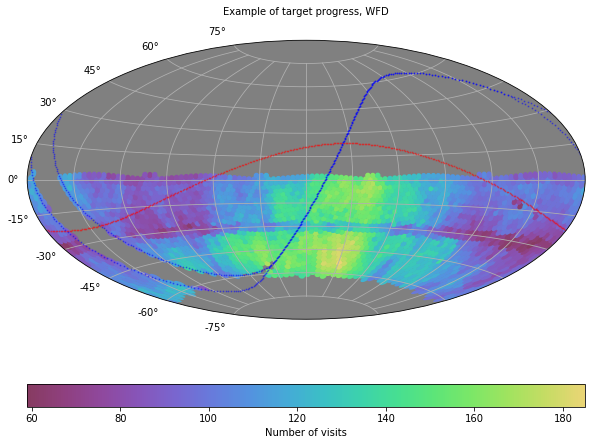

In [17]:
allband.plot(plotFunc=plots.BaseSkyMap())

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

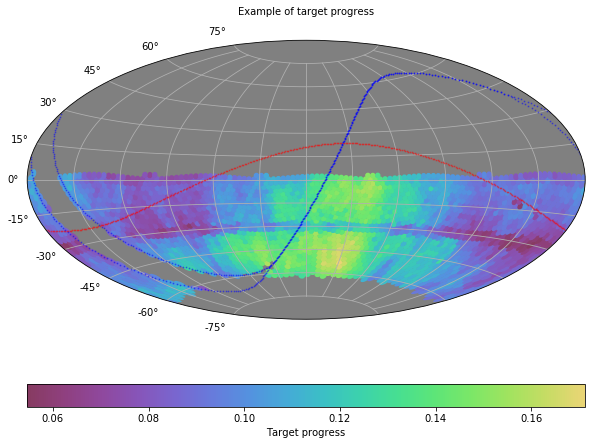

In [18]:
# Convert number of visits into 'progress' / area_need that is used in ranking.
m = metrics.CountRatioMetric()
progress = mb.MetricBundle(m, s, sql)
progress.metricValues = allband.metricValues/goal_visits_per_field
plotDict = {'figsize':(10, 8), 'xlabel':'Target progress', 'raCen': lmst_rad,
            'title': 'Example of target progress'}
progress.setPlotDict(plotDict)
progress.plot(plotFunc=plots.BaseSkyMap())

In [19]:
area_need = (1 - progress.metricValues) / (1 - allband.metricValues.sum()/(goal_visits_per_field*len(wfdfields)))

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

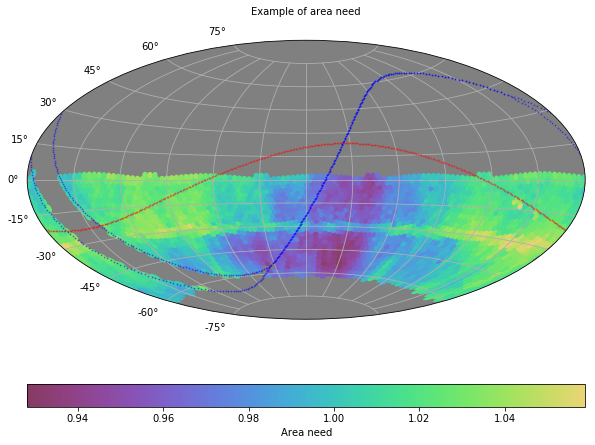

In [20]:
m = metrics.CountRatioMetric()
b = mb.MetricBundle(m, s, sql)
b.metricValues = area_need
plotDict = {'figsize':(10, 8), 'xlabel':'Area need', 'raCen': lmst_rad,
            'title': 'Example of area need'}
b.setPlotDict(plotDict)
b.plot(plotFunc=plots.BaseSkyMap())

Now let's look at the "time need" part of the area proposal ranking.

In [21]:
def time_window(deltaT, time_window_start=0.5, time_window_max=1.0, time_window_end=2.0, time_interval=1800.0):
    need = np.zeros(len(deltaT))
    ndeltaT = deltaT / time_interval
    need = (ndeltaT - time_window_start) / (time_window_max - time_window_start)
    need = np.where(ndeltaT < time_window_start, 0, need)
    need = np.where(ndeltaT > time_window_max, 1, need)
    need = np.where(ndeltaT > time_window_end, -1, need)
    return need

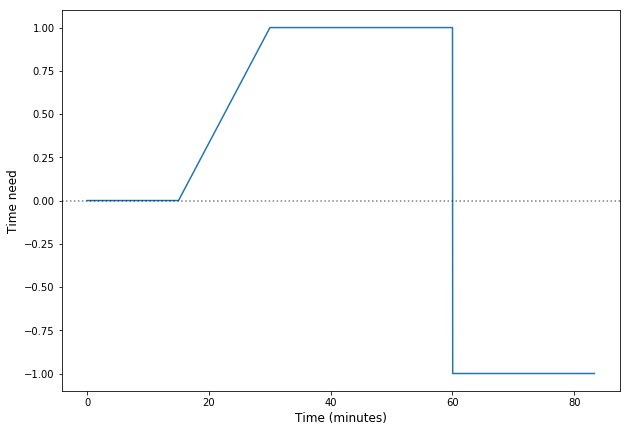

In [22]:
# time need ranking - for a given field, as time progresses.
plt.figure(figsize=(10, 7))
times = np.arange(0, 5000, 1)
tneed = time_window(times)
plt.plot(times/60, tneed)
plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Time (minutes)', fontsize='large')
plt.ylabel('Time need', fontsize='large')

In [23]:
# Current time need values for all fields in proposal? -- without considering if field is in a pair or not!
dt = (tnow - time.metricValues.filled()) * 24.0 * 60.0 * 60.0
time_need = time_window(dt)
print(tnow, time.metricValues.filled())

60353.1198032 [ 60154.06424769  60352.16313657  60248.02849537 ...,  60346.19642361
  60221.98820602  60353.04730324]


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

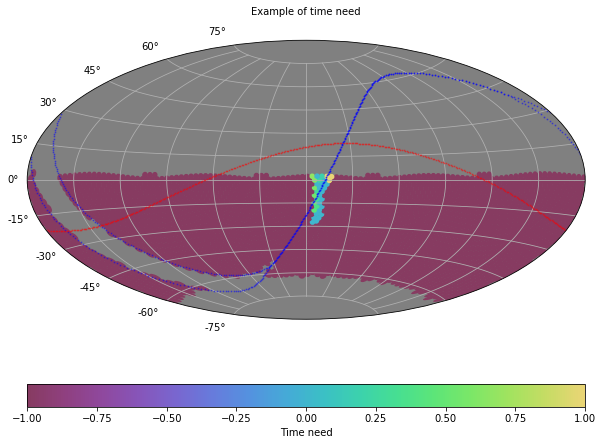

In [24]:
m = metrics.BaseMetric()
t = mb.MetricBundle(m, s, sql)
t.metricValues = ma.MaskedArray(data=time_need, mask=time.metricValues.mask)
plotDict = {'figsize':(10, 8), 'xlabel':'Time need', 'raCen': lmst_rad,
            'title': 'Example of time need'}
t.setPlotDict(plotDict)
t.plot(plotFunc=plots.BaseSkyMap())

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

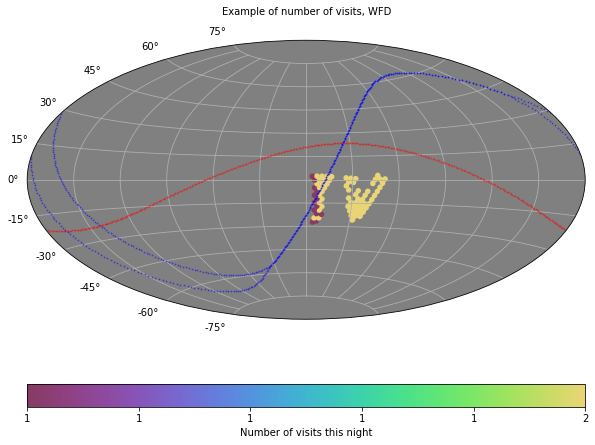

In [25]:
# but really, if field is already observed twice (or however many is specified as the limit of "group"), 
# then it is no longer needed  (NEED TO CHECK ON WTH SCHEDULER IS DOING HERE)
pairs.plot(plotFunc=plots.BaseSkyMap())

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

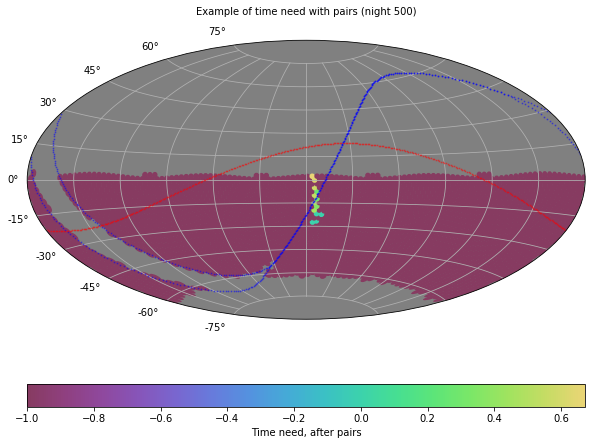

In [26]:
time_need_with_pairs = np.where(pairs.metricValues >= 2, -1, time_need)

m = metrics.BaseMetric()
tpairs = mb.MetricBundle(m, s, sql)
tpairs.metricValues = ma.MaskedArray(data=time_need_with_pairs, mask=time.metricValues.mask)
plotDict = {'figsize':(10, 8), 'xlabel':'Time need, after pairs', 'raCen': lmst_rad,
            'title': 'Example of time need with pairs (night 500)'}
tpairs.setPlotDict(plotDict)
tpairs.plot(plotFunc=plots.BaseSkyMap())

Let's look at the hour angle and airmass bonuses.

In [27]:
def haBonus(ha, ha_max):
    return (1 - np.abs(ha)/ha_max)

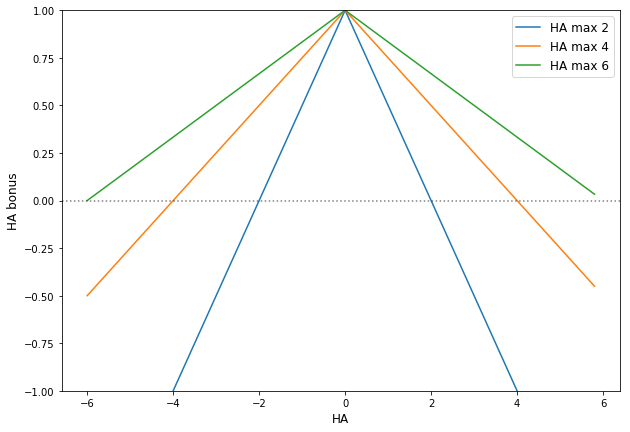

In [28]:
# HA bonus behaviour as function of HA & parameters (HAmax).
plt.figure(figsize=(10, 7))
ha = np.arange(-6, 6, .2)
for ha_max in (2, 4, 6):
    ha_bonus = haBonus(ha, ha_max)
    label = 'HA max %d' % (ha_max)
    plt.plot(ha, ha_bonus, label=label)
plt.legend(loc='upper right', fontsize='large', numpoints=1, fancybox=True)
plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.ylim(-1, 1)
plt.xlabel("HA", fontsize='large')
plt.ylabel("HA bonus", fontsize='large') 

In [29]:
wfdfieldsHA = (np.degrees(wfdfields['fieldRA']) - lmst_deg) / 360.0 * 24.0 
wfdfieldsHA = np.where(wfdfieldsHA < -12, wfdfieldsHA + 24, wfdfieldsHA)
wfdfieldsHA = np.where(wfdfieldsHA > 12, wfdfieldsHA - 24, wfdfieldsHA)
wfdfieldsHA.min(), wfdfieldsHA.max()

(-11.975119717221371, 11.986094149445297)

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

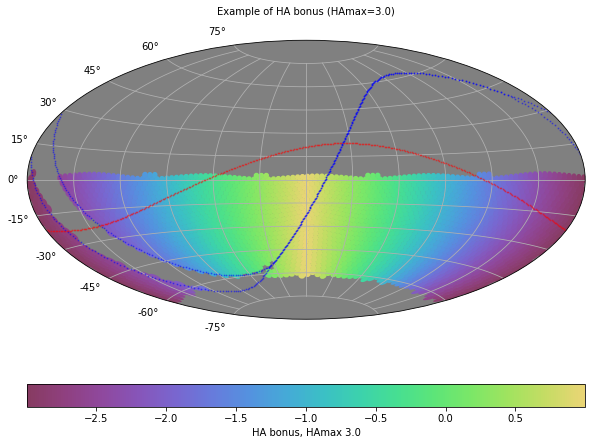

In [30]:
ha_max = 3.0
ha_need = ma.MaskedArray(data = haBonus(wfdfieldsHA, ha_max),
                         mask = False, fill_value=-2)
m = metrics.BaseMetric()
hab = mb.MetricBundle(m, s, sql)
hab.metricValues = ha_need
plotDict = {'figsize':(10, 8), 'xlabel':'HA bonus, HAmax %.1f' % (ha_max),
            'title': 'Example of HA bonus (HAmax=%.1f)' % (ha_max), 'raCen': lmst_rad}
hab.setPlotDict(plotDict)
hab.plot(plotFunc=plots.BaseSkyMap())

And look at airmass bonus.

In [31]:
def xBonus(x, x_max):
    return (x_max - x) / (x_max - 1)

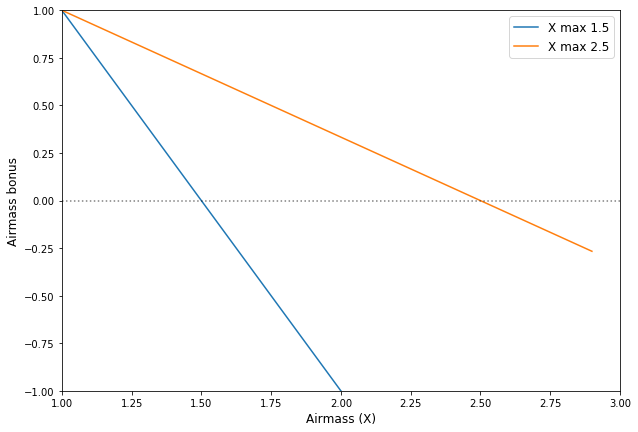

In [32]:
plt.figure(figsize=(10, 7))
x = np.arange(1, 3, .1)
for x_max in (1.5, 2.5):
    x_bonus = xBonus(x, x_max)
    label = 'X max %.1f' % (x_max)
    plt.plot(x, x_bonus, label=label)
plt.legend(loc='upper right', fontsize='large', numpoints=1, fancybox=True)
plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(1, 3)
plt.xlabel("Airmass (X)", fontsize='large')
plt.ylabel("Airmass bonus", fontsize='large')

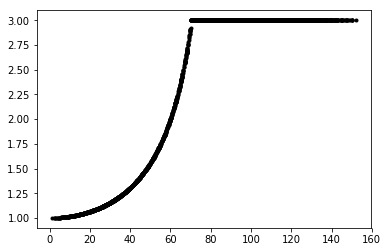

In [33]:
from lsst.sims.maf.stackers import raDec2AltAz
wfdfieldsAlt, wfdfieldsAz = raDec2AltAz(wfdfields['fieldRA'],wfdfields['fieldDec'], 
                      lsstSite.latitude_rad, lsstSite.longitude_rad, tsim, altonly=False)
zenith = np.pi/2.0 - wfdfieldsAlt
# This formula for airmass has some troubles at high values of zenith distance. 
# But I think it matches what opsim is using, so we'll just cut it off at some point.
wfdfieldsX = 1./np.cos(zenith)
wfdfieldsX = np.where(zenith > np.radians(70), 3, wfdfieldsX)
plt.plot(np.degrees(zenith), wfdfieldsX, 'k.')

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

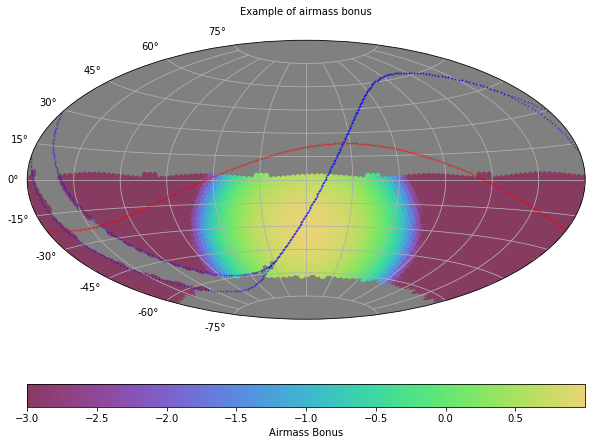

In [34]:
x_max = 1.5
x_need = ma.MaskedArray(data = xBonus(wfdfieldsX, x_max),
                        mask = False, fill_value=-2)
m = metrics.BaseMetric()
xb = mb.MetricBundle(m, s, sql)
xb.metricValues = x_need
plotDict = {'figsize':(10, 8), 'xlabel':'Airmass Bonus', 'raCen': lmst_rad,
            'title': 'Example of airmass bonus'}
xb.setPlotDict(plotDict)
xb.plot(plotFunc=plots.BaseSkyMap())

Combine for proposal ranking for its targets.

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

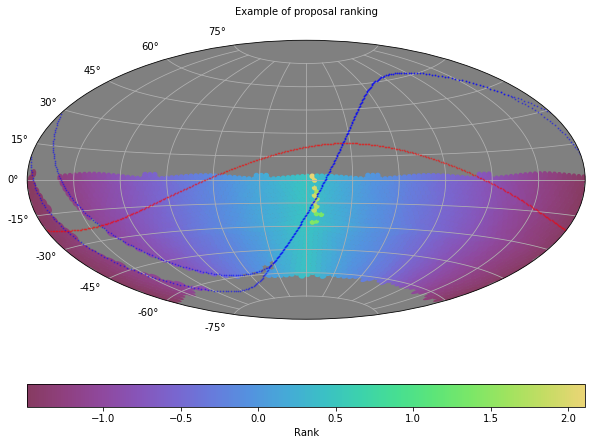

In [35]:
timeweight = 1
haweight = 0.5
xweight = 0
rank_weight = area_need + time_need_with_pairs * timeweight + ha_need * haweight + x_need * xweight

m = metrics.BaseMetric()
rank = mb.MetricBundle(m, s, sql)
rank.metricValues = rank_weight
plotDict = {'figsize':(10, 8), 'xlabel':'Rank', 'raCen': lmst_rad,
            'title': 'Example of proposal ranking'}
rank.setPlotDict(plotDict)
rank.plot(plotFunc=plots.BaseSkyMap())

Now let's go "up" a level and consider how the scheduler chooses the next field. 
This includes the proposal ranking, a "prop_boost" factor per proposal (to either try to keep proposals in balance over time, or set by the user in a config file), and a 'cost' based on the slew time as well as an additional cost to making filter changes.

In [36]:
def calcSlewCost(slewtime, cref, tref, tmax):
    timecost_dc = cref * (tmax - tref) / (tref - cref * tmax)
    timecost_dt = -tmax * (timecost_dc + 1.0)
    timecost_k = timecost_dc * timecost_dt
    cost = (timecost_k / (slewtime + timecost_dt) - timecost_dc - cref) / (1.0 - cref)
    return cost

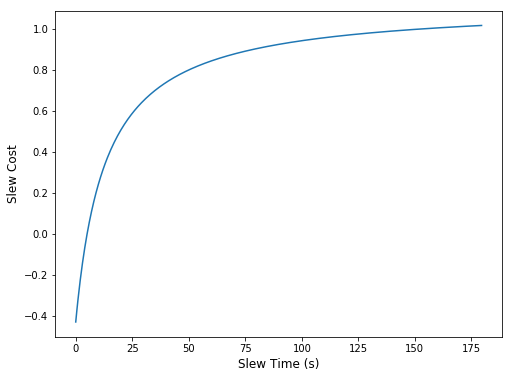

In [37]:
# cref = reference cost of tref slew
# tref = reference slew 
# tmax = max slew
tmax = 150
tref = 5
cref = 0.3
slewtimes = np.arange(0, 180, .5)
plt.figure(figsize=(8, 6))
plt.plot(slewtimes, calcSlewCost(slewtimes, cref, tref, tmax))
plt.xlabel('Slew Time (s)', fontsize='large')
plt.ylabel('Slew Cost', fontsize='large')

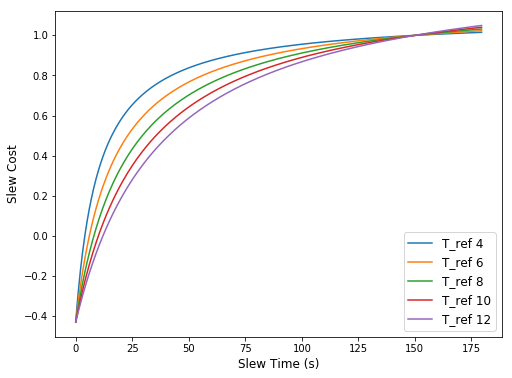

In [38]:
# cref = reference cost of tref slew
# tref = reference slew 
# tmax = max slew
tmax = 150
tref = 5
cref = 0.3
plt.figure(figsize=(8, 6))
for tref in (4, 6, 8, 10, 12):
    slewtimes = np.arange(0, 180, .5)
    plt.plot(slewtimes, calcSlewCost(slewtimes, cref, tref, tmax), label='T_ref %.0f' % (tref))
plt.legend(loc='lower right', fontsize='large')
plt.xlabel('Slew Time (s)', fontsize='large')
plt.ylabel('Slew Cost', fontsize='large')

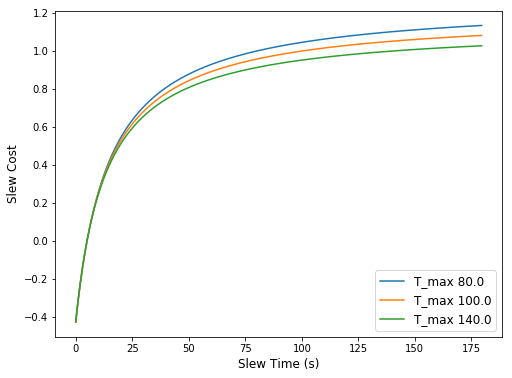

In [39]:
tmax = 150
tref = 5
cref = 0.3
plt.figure(figsize=(8, 6))
for tmax in (80, 100, 140):
    slewtimes = np.arange(0, 180, .5)
    plt.plot(slewtimes, calcSlewCost(slewtimes, cref, tref, tmax), label='T_max %.1f' % (tmax))
plt.legend(loc='lower right', fontsize='large')
plt.xlabel('Slew Time (s)', fontsize='large')
plt.ylabel('Slew Cost', fontsize='large')

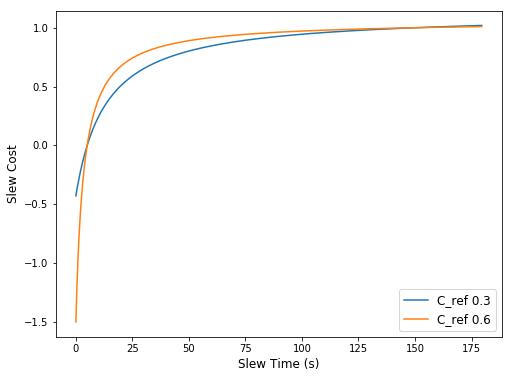

In [40]:
tmax = 150
tref = 5
cref = 0.3
plt.figure(figsize=(8, 6))
for cref in (0.3, 0.6):
    slewtimes = np.arange(0, 180, .5)
    plt.plot(slewtimes, calcSlewCost(slewtimes, cref, tref, tmax), label='C_ref %.1f' % (cref))
plt.legend(loc='lower right', fontsize='large')
plt.xlabel('Slew Time (s)', fontsize='large')
plt.ylabel('Slew Cost', fontsize='large')

In [41]:
def compute_filterchange_cost(time_since_last_change):
    filter_max_changes_avg_time=31557600.0
    filter_max_changes_avg_num=3000
    T = filter_max_changes_avg_time / filter_max_changes_avg_num
    cost = np.zeros(len(time_since_last_change), float)
    cost = 1.0 - time_since_last_change / T
    cost = np.where(time_since_last_change > T, 0, cost)
    return cost

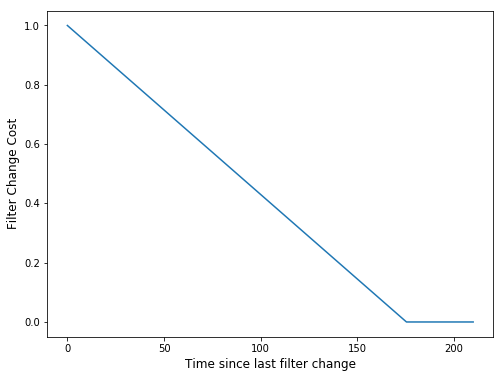

In [42]:
filtertimes = np.arange(0, 3.5*60*60, 10)
plt.figure(figsize=(8,6))
plt.plot(filtertimes/60.0, compute_filterchange_cost(filtertimes))
plt.xlabel('Time since last filter change', fontsize='large')
plt.ylabel('Filter Change Cost', fontsize='large')

In [43]:
# Slew times depend on where the telescope is pointing. 
telRA = np.radians(g.simData['fieldRA'][-1])
telDec = np.radians(g.simData['fieldDec'][-1])
telAlt, telAz = raDec2AltAz(np.array(telRA), np.array(telDec), 
                            lsstSite.latitude_rad, lsstSite.longitude_rad, 
                            np.array([tnow]))
telAlt = telAlt[0]
telAz = telAz[0]
print(telRA, telDec, telAlt, telAz)

1.82932791718 -0.0469151833319 1.06103960172 5.91145579384


In [44]:
class Telescope:
    """This class provides a kinematic model of the telescope

    The functionality provided is currently (June 18 2017) limited to
    calculating slew times. Putting the code into a class allows a
    simulator to consider many `Telescope`s at once, each with
    different parameters.

    Attributes
    ----------
    latitude : float
        The latitude of the telescope in radians. This attribute should not
        be changed on Telescope instances, since lsst.sims.speedObservatory.sky
        assumes the default value.
    longitude : float
        The longitude of the telescope in radians. This attribute should not
        be changed on Telescope instances, since lsst.sims.speedObservatory.sky
    filters : list of str
        The filters available on this telescope. This attribute should not
        be modified on instances.
    filterId : dict (keys are str, values are int)
        An integer ID assigned to each filter. This attribute should not
        be modified on instances.
    fovWidth : float
        The width of the field of view in radians.
    domSlitDiam : float
        The width of the dome slit in radians. TODO this assumes a circular
        dome slit, but I think it may actually be rectangular.
    raftWidth : float
        The width of a single raft in radians.
    minRotation : float
        The minimum angle of the rotator in radians.
    maxRotation : float
        The maximum angle of the rotator in radians.
    minAlt : float
        The minimum altitude that the telescope can point at in radians.
    maxAlt : float
        The maximum altitude that the telescope can point at in radians.
    domAltMaxSpeed : float
        The maximum rate of change in dome altitude in radians/s.
    domAltAccel : float
        The maximum acceleration in dome altitude in radians/s/s.
    domAltDecel : float
        The maximum deceleration in dome altitude in radians/s/s.
    domAzMaxSpeed : float
        The maximum rate of change in dome azimuth in radians/s.
    domAzAccel : float
        The maximum acceleration in dome azimuth in radians/s/s.
    domAzDecel : float
        The maximum deceleration in dome azimuth in radians/s/s.
    telAltMaxSpeed : float
        The maximum rate of change in telescope altitude in radians/s.
    telAltAccel : float
        The maximum acceleration in telescope altitude in radians/s/s.
    telAltDecel : float
        The maximum deceleration in telescope altitude in radians/s/s.
    telAzMaxSpeed : float
        The maximum rate of change in telescope azimuth in radians/s.
    telAzAccel : float
        The maximum acceleration in telescope azimuth in radians/s/s.
    telAzDecel : float
        The maximum deceleration in telescope azimuth in radians/s/s.
    rotMaxSpeed : float
        The maximum rate of change in rotator in radians/s.
    rotAccel : float
        The maximum acceleration of the rotator in radians/s/s.
    rotDecel : float
        The maximum deceleration of the rotator in radians/s/s.
    settleTime : float
        The number of seconds it takes for the instrument to settle.
    readoutTime : float
        The number of seconds it takes to read out an exposure from the camera.
    filterChangeTime : float
        The number of seconds it takes to change filters.
    """
    # non-configurable (AstronomicalSky uses these and I don't
    # want to slow it down by requiring it create a Telescope object)
    # (don't modify these on an instance)
    latitude = np.radians(-(30 + 14 / 60 + 40.7 / 3600))
    longitude = np.radians(-(70 + 44 / 60 + 57.9 / 3600))
    filters = ["u", "g", "r", "i", "z", "y"]
    filterId = {}
    for i, filter in enumerate(filters):
        filterId[filter] = i

    def __init__(self):
        self.fovWidth = np.radians(3.5)
        self.domSlitDiam = 2 * self.fovWidth
        self.raftWidth = self.fovWidth / 5
        self.minRotation = -np.pi/2
        self.maxRotation = np.pi/2

        # values from http://ops2.lsst.org/docs/current/system.html
        self.minAlt = np.radians(20.0)
        self.maxAlt = np.radians(86.5)

        # Kinematic and delay parameters for slew time computation

        # speed in rads/sec
        # acceleration in rads/second**2
        self.domAltMaxSpeed = np.radians(1.75)
        self.domAltAccel = np.radians(0.875)
        self.domAltDecel = np.radians(0.875)

        self.domAzMaxSpeed = np.radians(1.5)
        self.domAzAccel = np.radians(0.75)
        self.domAzDecel = np.radians(0.75)

        self.telAltMaxSpeed = np.radians(3.5)
        self.telAltAccel = np.radians(3.5)
        self.telAltDecel = np.radians(3.5)
        # assume accel == decel for calculations below
        # (easy to change but they are the same anyway and I'm  lazy)
        assert(self.telAltAccel == self.telAltDecel)

        self.telAzMaxSpeed = np.radians(7.0)
        self.telAzAccel = np.radians(7.0)
        self.telAzDecel = np.radians(7.0)
        assert(self.telAzAccel == self.telAzDecel)

        # not used in slew calculation
        self.rotMaxSpeed = np.radians(3.5)
        self.rotAccel = np.radians(1.0)
        self.rotDecel = np.radians(1.0)

        self.settleTime = 3
        self.readoutTime = 2
        self.filterChangeTime = 120
        
    def _uamSlewTime(self, d, vmax, a):
        dm = vmax**2 / a
        slewTime = np.where(d < dm, 2 * np.sqrt(d/a), 2 * vmax / a + (d - dm) / vmax)
        return slewTime
        """
        # if you accelerate uniformely to telAltMaxSpeed
        # and then slow down uniformely to zero, you'll travel
        # a distance v_max^2 / a
        if d < vmax**2 / a:
            # to travel a distance d/2 while accelerating at a rate a,
            # it takes time sqrt(2(d/2)/a)
            slewTime = 2 * np.sqrt(d / a)
        else:
            # the time to accelerate/decelerate to/from v_max is 2v_max / a
            # and the distance covered in those two steps is v_max^2 / a
            # so the total time is the accel/decel time plus the remaining
            # distance over v_max
            slewTime = 2 * vmax / a + (d - vmax**2 / a) / vmax
        return slewTime
        """

    def calcSlewTime(self, alt1, az1, filter1, alt2, az2, filter2, laxDome=False):
        """Calculates ``slew'' time

        Calculates the ``slew'' time necessary to get from alt1/az1/filter1
        to alt2/az2/filter2. The time returned is actually the time between
        the end of an exposure at alt1/az1 and the beginning of an exposure
        at alt2/az2, since it includes readout time in the ``slew'' time.

        Parameters
        ----------
        alt1 : float
            The altitude of the initial pointing.
        az1 : float
            The azimuth of the initial pointing.
        filter1 : str
            The filter used in the initial observation.
        alt2 : np.ndarray
            The altitude of the destination pointing.
        az2 : np.ndarray
            The azimuth of the destination pointing.
        filter2 : np.ndarray
            The filter to be used in the destination observation.
        laxDome : boolean
            If True, allow the dome to creep, model a dome slit, and don't
            require the dome to settle in azimuth. If False, adhere to the way
            SOCS calculates slew times (as of June 21 2017).

        Returns
        -------
        np.ndarray
            The number of seconds between the two specified exposures.

        Notes
        -----
        This method should really be called `calcInterExposureTime`, but to be
        consistent with other code/documentation, I've called it `calcSlewTime`.
        """

        # FYI this takes on the order of 10us for 1 slew calculation
        # or now vectorized .. 285 us to calculate slew times to 2293 (.12us per pointing)
    
        # TODO also assumes we never max out the cable wrap-around constraint
        deltaAlt = np.abs(alt2 - alt1)
        deltaAz  = np.abs(az2 - az1)

        deltaAz = np.minimum(deltaAz, np.abs(deltaAz - 2*np.pi))

        telAltSlewTime = self._uamSlewTime(deltaAlt, self.telAltMaxSpeed, self.telAltAccel)
        telAzSlewTime  = self._uamSlewTime(deltaAz,  self.telAzMaxSpeed,  self.telAzAccel)
        totTelTime = np.maximum(telAltSlewTime, telAzSlewTime)

        # open loop optics correction
        olTime = deltaAlt / np.radians(3.5)
        totTelTime += olTime

        settleAndOL = np.where(totTelTime > 0)
        totTelTime[settleAndOL] += np.maximum(0, self.settleTime - olTime[settleAndOL])        
        # readout puts a floor on tel time
        totTelTime = np.maximum(self.readoutTime, totTelTime)

        # now compute dome slew time
        if laxDome:
            totDomeTime = np.zeros(len(alt2), float)
            # model dome creep, dome slit, and no azimuth settle
            # if we can fit both exposures in the dome slit, do so
            sameDome = np.where(deltaAlt**2 + deltaAz**2 < self.fovWidth**2)

            # else, we take the minimum time from two options:
            # 1. assume we line up alt in the center of the dome slit so we
            #    minimize distance we have to travel in azimuth.
            # 2. line up az in the center of the slit
            # also assume:
            # * that we start out going maxspeed for both alt and az
            # * that we only just barely have to get the new field in the
            #   dome slit in one direction, but that we have to center the
            #   field in the other (which depends which of the two options used)
            # * that we don't have to slow down until after the shutter
            #   starts opening
            domDeltaAlt = deltaAlt
            # on each side, we can start out with the dome shifted away from
            # the center of the field by an amount domSlitRadius - fovRadius
            domDeltaAz = deltaAz - 2 * (self.domSlitDiam/2 - self.fovWidth/2)
            domAltSlewTime = domDeltaAlt / self.domAltMaxSpeed
            domAzSlewTime  = domDeltaAz  / self.domAzMaxSpeed
            totDomTime1 = np.maximum(domAltSlewTime, domAzSlewTime)

            domDeltaAlt = deltaAlt - 2 * (self.domSlitDiam/2 - self.fovWidth/2)
            domDeltaAz  = deltaAz
            domAltSlewTime = domDeltaAlt / self.domAltMaxSpeed
            domAzSlewTime  = domDeltaAz  / self.domAzMaxSpeed
            totDomTime2 = np.maximum(domAltSlewTime, domAzSlewTime)

            totDomTime = np.minimum(totDomTime1, totDomTime2)
            totDomTime[sameDome] = 0

        else:
            # the above models a dome slit and dome creep. However, it appears that
            # SOCS requires the dome to slew exactly to each field and settle in az
            domAltSlewTime = self._uamSlewTime(deltaAlt, self.domAltMaxSpeed, self.domAltAccel)
            domAzSlewTime  = self._uamSlewTime(deltaAz,  self.domAzMaxSpeed,  self.domAzAccel)
            # Dome takes 1 second to settle in az
            domAzSlewTime = np.where(domAzSlewTime > 0, domAzSlewTime + 1.0, domAzSlewTime)
            totDomTime = np.maximum(domAltSlewTime, domAzSlewTime)


        slewTime = np.maximum(totTelTime, totDomTime)

        # include filter change time if necessary
        filterChange = np.where(filter2 != filter1)
        slewTime[filterChange] = np.maximum(slewTime[filterChange], 
                                            self.filterChangeTime)

        # closed loop optics correction
        closeLoop = np.where(deltaAlt >= np.radians(9))
        slewTime[closeLoop] += 20

        return slewTime

In [45]:
telescope = Telescope()
slewtime = telescope.calcSlewTime(telAlt, telAz, 'g', wfdfieldsAlt, wfdfieldsAz, 'g', laxDome=False)
slewtime.min(), slewtime.max()

(2.0, 142.72410834458583)

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

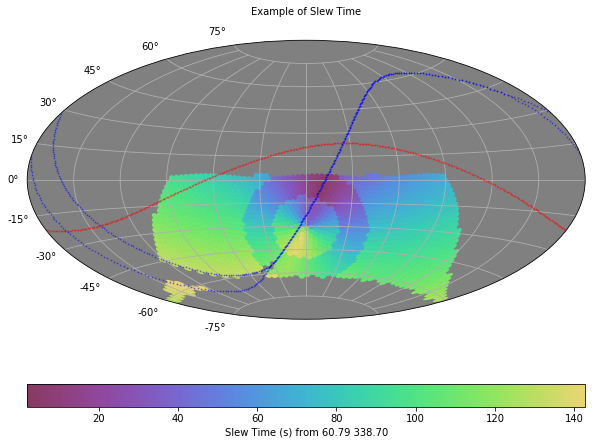

In [46]:
mask = np.where(wfdfieldsAlt < 0, True, False)
m = metrics.BaseMetric()
slewT = mb.MetricBundle(m, s, sql)
slewT.metricValues = ma.MaskedArray(data=slewtime, mask=mask)
plotDict = {'figsize':(10, 8), 'xlabel':'Slew Time (s) from %.2f %.2f' %(np.degrees(telAlt), np.degrees(telAz)),
            'title': 'Example of Slew Time', 'raCen': lmst_rad}
slewT.setPlotDict(plotDict)
slewT.plot(plotFunc=plots.BaseSkyMap())

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

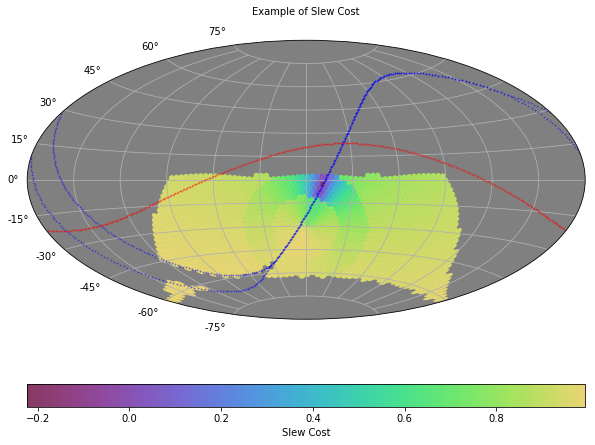

In [47]:
tmax = 150
tref = 5
cref = 0.3

m = metrics.BaseMetric()
slewcost = mb.MetricBundle(m, s, sql)
slewcost.metricValues = ma.MaskedArray(data=calcSlewCost(slewtime, cref, tref, tmax), mask=mask, fill_value=5)
plotDict = {'figsize':(10, 8), 'xlabel':'Slew Cost',
            'title': 'Example of Slew Cost', 'raCen': lmst_rad}
slewcost.setPlotDict(plotDict)
slewcost.plot(plotFunc=plots.BaseSkyMap())

/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:530: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


{'SkyMap': 1}

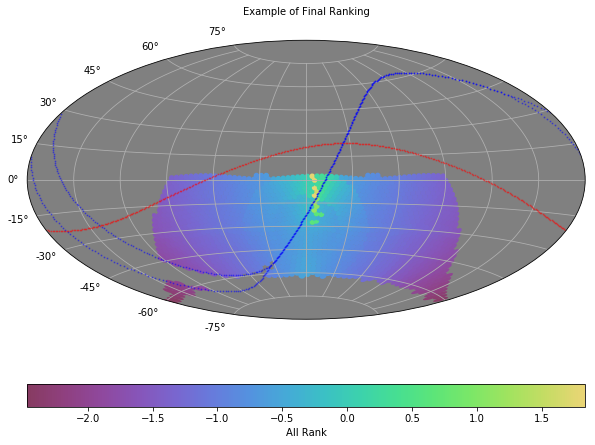

In [48]:
timeweight = 1
haweight = 0.5
xweight = 0
rank_weight = (area_need + time_need_with_pairs * timeweight + 
               ha_need * haweight + x_need * xweight - slewcost.metricValues.filled())

m = metrics.BaseMetric()
choice = mb.MetricBundle(m, s, sql)
choice.metricValues = ma.MaskedArray(data=rank_weight, mask=mask, fill_value=5)
plotDict = {'figsize':(10, 8), 'xlabel':'All Rank',
            'title': 'Example of Final Ranking', 'raCen': lmst_rad}
choice.setPlotDict(plotDict)
choice.plot(plotFunc=plots.BaseSkyMap())